In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
%matplotlib inline

# Importing data
test = pd.read_csv('dataset/test.csv')
train = pd.read_csv('dataset/train.csv')

y_feature = 'SalePrice'

# Droping All the columns with more than half of rows nans 
# simply because they might not be as important as the other columns
train.dropna(thresh=train.shape[0] / 2, axis=1, inplace=True)

# Getting the features with missing values
# Divifing the dataset into categorical and numerical
categorical_data = train.select_dtypes('object')
numerical_data = train.select_dtypes(['float64', 'int64'])

In [93]:
# Data imputation: imputate data using any model (KNN in this case) by first
# dividing the df['column'] of the dataset into null parts and non-null parts

""" returns the index of columns with nan property. """
def getNaIndexes(feature, df):
    return list(df[feature].index[df[feature].apply(np.isnan)])

"""
    feature: the column of interest within the dataframe
    df: dataframe
    l: list of indexes
"""
def divideByNA(feature, l, df):
    X, y, X_test = [], [], []
    
    for i in range(0, df.shape[0]):
        if i in l:
            X_test.append(df.iloc[i][y_feature])
        else:
            X.append(df.iloc[i][feature])
            y.append(df.iloc[i][y_feature])
            
    return np.reshape(X, (-1, 1)),  np.reshape(y, (-1, 1)),  np.reshape(X_test, (-1, 1))

"""
    feature: gets the name of the column with na values
    df: dataset containing the info we need
    model: the model type that will predict the missing values
    returns the new imputated dataframe as well as the model for further imputations
"""
def imputeData(feature, df, model):
    # Get the na indexes
    l = getNaIndexes(feature, df)
    
    # Split the data based on the nas
    X, y, X_test = divideByNA(feature, l, df)
    
    # Fit the data
    model.fit(X, y.ravel())
    
    # Make the prediction
    y_test = model.predict(X_test)
    
    # Apply the new values
    c = list(df[feature].copy())
    index = 0
    
    for i in range(df.shape[0]):
        if i in l:
            c[i] = y[index]
            index += 1
    
    df[feature] = c
    
    return df[feature], model

def imputeGivenData(fs):
    l = dict(train[fs].isna().any())
    m = KNeighborsClassifier(n_neighbors=train.shape[0]//3)

    for z in l:
        if l[z]:
            train[z], m = imputeData(z, train, m)

In [101]:
initial_fs = list(train.corr()['SalePrice'].nlargest(22)[1:].keys())
imputeGivenData(initial_fs)

In [128]:
def f(l, k):
    n = len(l)
    d = []
    if k == 1 or k == n: return l
    Range = n - k + 1
    for i in range(0, Range):
        nl = f(l[i + 1:], k - 1)
        for z in nl:
            if k == len(nl) + 1:
                nl.append(l[i])
                d.append(nl)
                break
            if type(z) != list:
                d.append([z, l[i]])
            else:
                zz = z.copy()
                zz.append(l[i])
                d.append(zz)
    return d

# Finding the features by using automation
def tryOut(features, n):
    
    combs = f(features, n)
    r2s = {}
    index  = 0
    
    r2s['combination'] = []
    r2s['mean'] = []
    r2s['std'] = []
    r2s['r2'] = []
    
    for comb in combs:
        reg = LinearRegression()
        X = train[comb]
        y = train[y_feature]
        
        r2s['combination'].append(comb)
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
        reg.fit(X_train, y_train)
        y_pred = reg.predict(X_test)
        r2 = r2_score(y_pred, y_test)
        
        r2s['r2'].append(r2)
        
        d = list(cross_val_score(reg, X,  y, cv=5))
        
        r2s['mean'].append(np.mean(d))
        r2s['std'].append(np.std(d))
        
        index += 1
        
    return r2s

r = pd.DataFrame(tryOut(list(train.corr()['SalePrice'].nlargest(22)[1:].keys()), 6))

In [130]:
r.head(10)

,combination,mean,std,r2
0,"[1stFlrSF, TotalBsmtSF, GarageArea, GarageCars...",0.748216,0.052011,0.655776
1,"[FullBath, TotalBsmtSF, GarageArea, GarageCars...",0.746576,0.052072,0.654659
2,"[TotRmsAbvGrd, TotalBsmtSF, GarageArea, Garage...",0.745643,0.052658,0.652363
3,"[YearBuilt, TotalBsmtSF, GarageArea, GarageCar...",0.754981,0.053135,0.667889
4,"[YearRemodAdd, TotalBsmtSF, GarageArea, Garage...",0.753578,0.055703,0.659698
5,"[Fireplaces, TotalBsmtSF, GarageArea, GarageCa...",0.750523,0.054090,0.658155
6,"[BsmtFinSF1, TotalBsmtSF, GarageArea, GarageCa...",0.754987,0.059916,0.683141
7,"[WoodDeckSF, TotalBsmtSF, GarageArea, GarageCa...",0.752076,0.050560,0.654455
8,"[2ndFlrSF, TotalBsmtSF, GarageArea, GarageCars...",0.747743,0.052109,0.653875
9,"[OpenPorchSF, TotalBsmtSF, GarageArea, GarageC...",0.745495,0.051755,0.654671


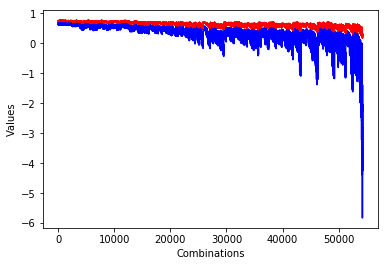

In [131]:
# Plotting
plt.plot(r.index,r['r2'], color='b')
plt.plot(r.index,r['mean'], color='r')
plt.xlabel('Combinations')
plt.ylabel('Values')
plt.show()

In [184]:
abs(r['r2']).nsmallest(50)

33609    0.000024
41383    0.000043
41482    0.000058
39497    0.000061
40973    0.000069
53395    0.000099
39223    0.000159
44694    0.000162
53593    0.000189
50235    0.000203
41586    0.000209
47121    0.000217
34356    0.000258
47124    0.000258
39555    0.000275
26788    0.000318
29252    0.000344
38737    0.000354
52961    0.000366
41515    0.000397
50197    0.000418
28137    0.000419
28964    0.000444
41047    0.000467
35430    0.000498
45498    0.000527
35385    0.000529
41228    0.000529
41311    0.000557
49280    0.000560
40523    0.000563
45780    0.000575
33156    0.000592
33030    0.000602
42510    0.000609
45471    0.000622
42536    0.000640
34349    0.000643
41439    0.000663
42534    0.000672
50638    0.000709
38669    0.000748
33632    0.000751
45037    0.000787
53037    0.000799
47772    0.000835
29266    0.000846
47673    0.000852
54077    0.000853
46983    0.000885
Name: r2, dtype: float64

In [175]:
z = train['SalePrice'].mean() / train['SalePrice'].std()
print(z - 0.25, z + 0.25)

2.027385396040747 2.527385396040747


In [192]:
l = r.iloc[33609].combination
test[l].isna().any()

BsmtUnfSF      True
LotArea       False
HalfBath      False
WoodDeckSF    False
FullBath      False
GarageCars     True
dtype: bool

In [191]:
reg = LinearRegression()
        
reg.fit(train[l], train['SalePrice'])
y_pred = reg.predict(test[l])

list(cross_val_score(reg, train[l],  train['SalePrice'], cv=3))

[0.5786933790175827, 0.5718414107435911, 0.49390894413102526]